# First steps: a synthetic data study

In this part of the tutorial, we'll take a [`myokit.Simulation`](https://myokit.readthedocs.io/api_simulations/Simulation.html) and wrap it in a [`pints.ForwardModel`](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).
We'll then use this `ForwardModel` to generate some data, add synthetic noise, and set up a [`pints.SingleOutputProblem`](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem).
Finally, we'll define an [`ErrorMeasure`](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ErrorMeasure) on this problem and use an [optimiser](https://pints.readthedocs.io/en/latest/optimisers/index.html) to find that parameters that minimise it.

The steps we follow here are roughly equal to those followed in the [PINTS examples](https://github.com/pints-team/pints/tree/master/examples), in particular ["Optimisation: First example"](https://github.com/pints-team/pints/blob/master/examples/optimisation/first-example.ipynb).

## Wrapping a simulation in a pints.ForwardModel

To 




In [1]:
import myokit
import pints

class Model(pints.ForwardModel):
    def __init__(self):
        
        # Load model and protocol
        self.model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        self.protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
        
        # Bring model to steady state for -80mV
        a_inf = self.model.get('ikr.act.inf').pyfunc()(-80)
        r_inf = self.model.get('ikr.rec.inf').pyfunc()(-80)
        self.model.get('ikr.act').set_state_value(a_inf)
        self.model.get('ikr.rec').set_state_value(r_inf)

        # Create a simulation
        self.sim = myokit.Simulation(self.model, self.protocol)
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):
        
        # Reset the simulation
        self.sim.reset()
        
        # Update the parameters
        for i, p in enumerate(parameters):
            #self.sim.set_constant('ikr.p' + str(1 + i), p)
            pass
        
        # Run a simulation
        tmax = times[-1] + 1
        log = self.sim.run(tmax, log_times=times, log=['ikr.IKr'])
        
        return log['ikr.IKr']
        

Let's try and run a simulation with this model:

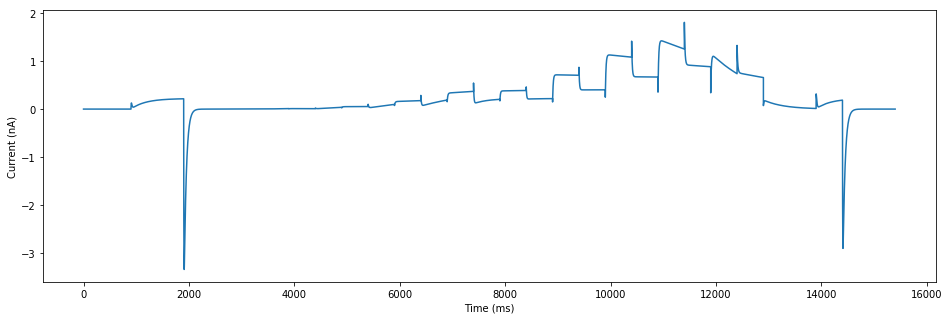

In [3]:
import matplotlib.pyplot as plt
import numpy as np

model = Model()
t_max = 15400
times = np.arange(0, t_max, 0.1)

# Define a parameter vector
parameters = [3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2]

values = model.simulate(parameters, times)

# Show the results
plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(times, values)
plt.show()

## Generating noisy data





### Intermezzo: Model?

The word "model" gets a lot of mileage in computational electrophysiology.
This can get a bit confusing, some of the main uses in this tutorial are shown again here:

- An expression system, or even an isolated myocyte, acts as a biological model for the true system of interest: myocytes in the intact human heart.
- A model of an ion current is a set of mathematical equations describing how the state of the underlying ion channels changes in response to a voltage signal. This is the sense in which Myokit uses the word "model".
- A model in PINTS is something you throw parameters at, that then returns a signal. This is a parametrisable simulation in Myokit.
- A noise model describes how the output of a measurement is affected by different noise sources (e.g. anything that isn't the system of interest).
